In [34]:
import multiprocessing as mp
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F

from attacker import LinfPGDAttack
from data import mnist, fashion_mnist
from models import LatentClf
from simulation.make_data import get_dataloader
from training import OnManifoldPerturbation
from training.vae_train import ClassifierTrainer, VAETrainer
from utils import load_data, load_checkpoint, concatenate, save_data
import pandas as pd

random_seed = 999

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)


def generate_adv(net, test_loader, device, epsilon=1.0, alpha=0.01, k=7):
    net.eval()
    adv = LinfPGDAttack(net, epsilon=epsilon, alpha=alpha, k=k)
    
    advs = None
    correct_ys = None
    total = None
    total_ys = None
    perturbs = None
    for X, y in test_loader:
        adv_x = adv.perturb(X.to(device), y.long().to(device))
        perturbs = concatenate(perturbs, (adv_x - X.to(device)).detach().cpu().numpy())
        out = net(adv_x)
        out = F.softmax(out, dim=1)
        _, predicted = out.max(1)
        idx = ~predicted.eq(y.to(device))
        advs = concatenate(advs, adv_x[idx].detach().cpu().numpy())
        correct_ys = concatenate(correct_ys, y[idx].detach().cpu().numpy())
        total = concatenate(total, adv_x.detach().cpu().numpy())
        total_ys = concatenate(total_ys, y.detach().cpu().numpy())
        
    adv_dataloader = get_dataloader(advs, correct_ys, drop_last=False, shuffle=False)
    total_adv_dataloader = get_dataloader(total, total_ys, drop_last=False, shuffle=False)
    
    return adv_dataloader, perturbs, advs, correct_ys, total_adv_dataloader


def accuracy2(net, test_loader, device):
    net.eval()
    correct = 0
    total_set = 0

    for X, y in test_loader:
        X = X.to(device)
        out = net(X)
        out = F.softmax(out, dim=1)
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        correct += predicted.eq(y.to(device)).sum().item()

        total_set += X.size(0)

    benign_acc = correct / total_set
    print('accuracy: {0}'.format(benign_acc))
    return benign_acc, correct, total_set


def accuracy3(net, test_loader, device, epsilon=1.0, alpha=0.01, k=7):
    net.eval()
    correct = 0
    total_set = 0
    
    adv = LinfPGDAttack(net, epsilon=epsilon, alpha=alpha, k=k)

    for X, y in test_loader:
        adv_x = adv.perturb(X.to(device), y.long().to(device))
        
        out = net(adv_x)
        out = F.softmax(out, dim=1)
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        correct += predicted.eq(y.to(device)).sum().item()

        total_set += X.size(0)

    benign_acc = correct / total_set
    print('accuracy: {0}'.format(benign_acc))
    return benign_acc, correct, total_set


def accuracy(net, test_loader, device, epsilon=1.0, alpha=0.01, k=7):
    net.eval()
    benign_correct = 0
    adv_correct = 0
    total_set = 0
    correct_list = None
    correct_label = None
    adv_list = None
    benign_softmax_list = None
    correct_softmax_list = None
    adversarial_softmax_list = None
    correct_adversarial_softmax_list = None

    adv = LinfPGDAttack(net, epsilon=epsilon, alpha=alpha, k=k)

    for X, y in test_loader:
        X = X.to(device)
        out = net(X)
        out = F.softmax(out, dim=1)
        benign_softmax_list = concatenate(benign_softmax_list, out.detach().cpu().numpy())
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        benign_correct += predicted.eq(y.to(device)).sum().item()

        correct_softmax_list = concatenate(correct_softmax_list, out[idx].detach().cpu().numpy())
        correct_list = concatenate(correct_list, X[idx].detach().cpu().numpy())
        correct_label = concatenate(correct_label, y[idx].detach().cpu().numpy())

        adv_x = adv.perturb(X.to(device), y.long().to(device))

        perturbation = adv_x - X
        out = net(adv_x)
        out = F.softmax(out, dim=1)
        adversarial_softmax_list = concatenate(adversarial_softmax_list, out.detach().cpu().numpy())
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        correct_adversarial_softmax_list = concatenate(correct_adversarial_softmax_list, out[idx].detach().cpu().numpy())
        adv_correct += predicted.eq(y.to(device)).sum().item()

        adv_list = concatenate(adv_list, perturbation.detach().cpu().numpy())

        total_set += X.size(0)

    benign_acc = benign_correct / total_set
    adv_acc = adv_correct / total_set
    print('benign accuracy: {0}\tadversarial accuracy: {1}'.format(benign_acc, adv_acc))
    return benign_acc, adv_acc, correct_list, correct_label, adv_list, correct_softmax_list, correct_adversarial_softmax_list, benign_softmax_list, adversarial_softmax_list


def make_perturbed_data(classifier, gan, l_clf, loader, device, epsilon=0.3, k=7, alpha=0.01, filter_=False):
    on_adv = OnManifoldPerturbation(classifier, gan, device, eta=epsilon, k=k, alpha=alpha)

    on_adv_Xs = None
    on_ys = None
    on_zs = None
    on_original_zs = None
    attack_succ_idxs = None
    orig_X = None
    orig_y = None

    print('creating perturbed data..')

    for X, y in loader:
        #     X = X.reshape((X.shape[0], -1))
        z, z_pert, adv_x = on_adv.perturb(X.to(device), y.long().to(device))
        on_adv_Xs = concatenate(on_adv_Xs, adv_x.detach().cpu().numpy())
        on_zs = concatenate(on_zs, z_pert.detach().cpu().numpy())
        on_ys = concatenate(on_ys, y.detach().cpu().numpy())
        on_original_zs = concatenate(on_original_zs, z.detach().cpu().numpy())
        orig_X = concatenate(orig_X, X.detach().numpy())
        orig_y = concatenate(orig_y, y.detach().numpy())

        f_x = classifier(adv_x)
        f_x = F.softmax(f_x, dim=1)
        _, predicted = f_x.max(1)

        idxs = ~predicted.eq(y.to(device))
        attack_succ_idxs = concatenate(attack_succ_idxs, idxs.detach().cpu().numpy())


    adv_loader = get_dataloader(on_adv_Xs, on_ys)
    z_loader = get_dataloader(on_zs, on_ys)

    on_xs = None
    on_ys = None
    on_preds = None

    print('filtering perturbed data..')

    for x_tilde, y in adv_loader:
        out, _ = gan.encoder(x_tilde.to(device))
        out = l_clf(out.unsqueeze(1))
        out = F.softmax(out, dim=1)
        _, pred = out.max(1)

        idx = pred.eq(y.to(device))

        on_adv_filtered = x_tilde[idx].detach().cpu().numpy()
        on_adv_filtered_label = y[idx].detach().cpu().numpy()

        on_xs = concatenate(on_xs, on_adv_filtered)
        on_ys = concatenate(on_ys, on_adv_filtered_label)
        on_preds = concatenate(on_preds, pred.detach().cpu().numpy())

    final_loader = get_dataloader(on_xs, on_ys)

    if filter_:

        filtered_onxs = None
        filtered_onys = None

        print('organizing training data..')

        for x_tilde, y in final_loader:
            out = classifier(x_tilde.to(device))
            f_x = F.softmax(out, dim=1)
            _, predicted = f_x.max(1)
            idxs = ~predicted.eq(y.to(device))

            filtered_onxs = concatenate(filtered_onxs, x_tilde[idxs].detach().numpy())
            filtered_onys = concatenate(filtered_onys, y[idxs].detach().numpy())

        total_X = concatenate(orig_X, on_xs)
        total_y = concatenate(orig_y, on_ys)

        final_loader = get_dataloader(filtered_onxs, filtered_onys)

    return final_loader


def analysis_per_sparsity(model_type, cuda_num, data_type, device, train_type, loader, test_loader, EPOCHs=10,
                          retrain_models=False, onadv_loader=None, onadv_test_loader=None, offadv_test_loader=None,
                          sparsity_ratio=0.9, epsilon=1.0, alpha=0.1, k=7):
    assert train_type in ['base', 'robust_train', 'original_robust',
                          'onoff', 'trades'], "train type must be one of ['base', 'robust', 'original_robust', 'onoff']"

    clf = ClassifierTrainer(model_type, cuda_num, loader, test_loader)
    regularize = True
    if sparsity_ratio == 0.:
        regularize = False
        
    orig_file = Path('./simulation/%s/base_%s.pt' % (data_type, model_type))
#     if train_type == 'base' and sparsity_ratio == 0:
#         clf_state = torch.load(orig_file)
#         clf.classifier.load_state_dict(clf_state)
#         classifier = clf.classifier
#     else:
    my_file = Path('./simulation/%s/%s_v2_%s_sparsity%s.pt' % (
        data_type, train_type, model_type, str(sparsity_ratio).replace('.', '_')))
    
    if sparsity_ratio == 0 and train_type == 'base':
        my_file = orig_file
        
    print(my_file)

    if my_file.exists() and not retrain_models:
        print('loading ', my_file)
        clf_state = torch.load(my_file)
        clf.classifier.load_state_dict(clf_state)
        classifier = clf.classifier
    else:
        clf.classifier.load_state_dict(torch.load(orig_file))
        clf.classifier.to(device)
        clf.EPOCH = EPOCHs
        if train_type == 'onoff':
            clf.train(regularize=regularize, ratio=sparsity_ratio, onoff=True, onmanifold_loader=onadv_loader)
        elif train_type == 'original_robust':
            clf.train(regularize=regularize, ratio=sparsity_ratio, AT=True, epsilon=epsilon, alpha=alpha, k=k)
#             elif train_type == 'robust':
#                 clf.train(regularize=regularize, ratio=sparsity_ratio, epsilon=0.3, alpha=0.073, k=7)
        else:
            clf.train(regularize=regularize, ratio=sparsity_ratio)

        classifier = clf.classifier
        torch.save(classifier.cpu().state_dict(), my_file)
    classifier.to(device)
    
#     offadv_test_loader
    
    benign_acc, benign_correct, benign_total = accuracy2(classifier, test_loader, device)
    off_acc, off_correct, off_total = accuracy2(classifier, offadv_test_loader, device)
#     off_acc, off_correct, off_total = accuracy3(classifier, test_loader, device, epsilon=epsilon, alpha=alpha, k=k)
    on_acc, on_correct, on_total = accuracy2(classifier, onadv_test_loader, device)
    
#     normal_acc = (benign_correct + on_correct) / (benign_total + on_total)
    normal_acc = (on_total/benign_total * benign_correct + on_correct) / (2 * on_total)
    
    return benign_acc, off_acc, on_acc, normal_acc, benign_correct, on_correct, benign_total, on_total

#     acc, adv_acc, _, _, advs, benign_softmax_list, adversarial_softmax_list, benign_softmax_list2, adversarial_softmax_list2 = accuracy(classifier, test_loader, device,
#                                                                                        epsilon=epsilon, alpha=alpha,
#                                                                                        k=k)
    
#     onadv_acc, _, _, _, _, onadv_softmax_list, _, onadv_softmax_list2, _ = accuracy(classifier, onadv_test_loader, device,epsilon=epsilon, alpha=alpha, k=k)
#     return acc, adv_acc, onadv_acc, advs, benign_softmax_list, adversarial_softmax_list, onadv_softmax_list, benign_softmax_list2, adversarial_softmax_list2, onadv_softmax_list2


def run_sparsity(model_type, cuda_num, data_type, sparsity_ratio, device, retrain_models = True, EPOCHs = 10, epsilon=1.0, alpha=0.01, k=7):
    
    data_loader, test_loader, _ = mnist(128)
    ## LOAD ALL
    state_dict = load_checkpoint(base_path='./simulation/results', dataset_name='mnist', net_name='vae',
                                 is_best=False, filename='chkpoint_epoch%d.pt' % 14)
#     trainer = VAETrainer(data_loader, cuda_num=2)
#     trainer.gan.load_state_dict(state_dict)
#     gan = trainer.gan

    l_clf = LatentClf()
    l_clf.load_state_dict(torch.load('./simulation/%s/mnist_l_clf.pt' % data_type))

#     e_, k_, alpha_ = 0.3, 10, 0.073
#     datafile = Path('./simulation/%s/onmanifold_%s_%s_k%se%s_loader.pkl'%(data_type, data_type, model_type, str(k_),str(e_).replace('.','_')))
    datafile = Path('./simulation/%s/onmanifold_MNIST_lenet_loader.pkl'%data_type)
    onadv_test_loader = load_data('./simulation/%s/onmanifold_test_%s_%s_loader.pkl'%(data_type, data_type, model_type))
    offadv_test_loader = load_data('./simulation/%s/offmanifold_test_%s_%s_loader.pkl'%(data_type, data_type, model_type))
    onmanifold_train_loader = load_data(datafile)
    
    acc_result = {
        'normal_acc': None,
        'normal_adv_acc': None,
        'normal_onadv_acc': None,
        'normal_onbenign_acc': None,
        'normal_benign_correct': None,
        'normal_benign_total': None,
        'normal_on_correct': None,
        'normal_on_total': None,
        'on_acc': None,
        'on_adv_acc': None,
        'on_onadv_acc': None,
        'on_onbenign_acc': None,
        'on_benign_correct': None,
        'on_benign_total': None,
        'on_on_correct': None,
        'on_on_total': None,
        'off_acc': None,
        'off_adv_acc': None,
        'off_onadv_acc': None,
        'off_onbenign_acc': None,
        'off_benign_correct': None,
        'off_benign_total': None,
        'off_on_correct': None,
        'off_on_total': None,
        'onoff_acc': None,
        'onoff_adv_acc': None,
        'onoff_onadv_acc': None,
        'onoff_onbenign_acc': None,
        'onoff_benign_correct': None,
        'onoff_benign_total': None,
        'onoff_on_correct': None,
        'onoff_on_total': None,
    }

#     softmax_result = {
#         'normal_benign_softmax': None,
#         'on_benign_softmax': None,
#         'off_benign_softmax': None,
#         'onoff_benign_softmax': None,
        
#         'normal_adv_softmax': None,
#         'on_adv_softmax': None,
#         'off_adv_softmax': None,
#         'onoff_adv_softmax': None,
        
#         'normal_onadv_softmax': None,
#         'on_onadv_softmax': None,
#         'off_onadv_softmax': None,
#         'onoff_onadv_softmax': None,
#     }
    
#     total_softmax_result = {
#         'normal_benign_softmax': None,
#         'on_benign_softmax': None,
#         'off_benign_softmax': None,
#         'onoff_benign_softmax': None,
        
#         'normal_adv_softmax': None,
#         'on_adv_softmax': None,
#         'off_adv_softmax': None,
#         'onoff_adv_softmax': None,
        
#         'normal_onadv_softmax': None,
#         'on_onadv_softmax': None,
#         'off_onadv_softmax': None,
#         'onoff_onadv_softmax': None,
#     }

#     adv_data = {
#         'normal_adv_lists': None,
#         'on_adv_lists': None,
#         'off_adv_lists': None,
#         'onoff_adv_lists': None
#     }

    # normal
#     acc_result['normal_acc'], acc_result['normal_adv_acc'], acc_result['normal_onadv_acc']
    acc_result['normal_acc'], acc_result['normal_adv_acc'], acc_result['normal_onadv_acc'], acc_result['normal_onbenign_acc'], acc_result['normal_benign_correct'],acc_result['normal_on_correct'],acc_result['normal_benign_total'],acc_result['normal_on_total'] = analysis_per_sparsity(model_type, cuda_num, data_type, device,
                                                                               'base', data_loader, test_loader, EPOCHs=EPOCHs, onadv_test_loader=onadv_test_loader, offadv_test_loader=offadv_test_loader,
                                                                               retrain_models=retrain_models, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
    
    acc_result['on_acc'], acc_result['on_adv_acc'], acc_result['on_onadv_acc'], acc_result['on_onbenign_acc'], acc_result['on_benign_correct'],acc_result['on_on_correct'],acc_result['on_benign_total'],acc_result['on_on_total']  = analysis_per_sparsity(model_type, cuda_num, data_type, device,
                                            'robust_train', onmanifold_train_loader, test_loader, EPOCHs=EPOCHs, onadv_test_loader=onadv_test_loader, offadv_test_loader=offadv_test_loader,
                                            retrain_models=retrain_models, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
    
    acc_result['off_acc'], acc_result['off_adv_acc'], acc_result['off_onadv_acc'], acc_result['off_onbenign_acc'], acc_result['off_benign_correct'],acc_result['off_on_correct'],acc_result['off_benign_total'],acc_result['off_on_total'] = analysis_per_sparsity(model_type, cuda_num, data_type, device,
                                                       'original_robust', data_loader, test_loader, EPOCHs=EPOCHs,
                                                       retrain_models=retrain_models, onadv_test_loader=onadv_test_loader, offadv_test_loader=offadv_test_loader,
                                                       sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
    
    acc_result['onoff_acc'], acc_result['onoff_adv_acc'], acc_result['onoff_onadv_acc'], acc_result['onoff_onbenign_acc'],acc_result['onoff_benign_correct'],acc_result['onoff_on_correct'],acc_result['onoff_benign_total'],acc_result['onoff_on_total'] = analysis_per_sparsity(model_type, cuda_num, data_type, device,
                                                           'onoff', data_loader, test_loader, EPOCHs=EPOCHs,
                                                           retrain_models=retrain_models, onadv_test_loader=onadv_test_loader, offadv_test_loader=offadv_test_loader,
                                                           onadv_loader=onmanifold_train_loader,
                                                           sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
    
    return acc_result
#     acc_result['normal_acc'], acc_result['normal_adv_acc'], acc_result['normal_onadv_acc'], adv_data['normal_adv_lists'], softmax_result['normal_benign_softmax'], \
#     softmax_result['normal_adv_softmax'], softmax_result['normal_onadv_softmax'], total_softmax_result['normal_benign_softmax'], \
#     total_softmax_result['normal_adv_softmax'], total_softmax_result['normal_onadv_softmax'] = analysis_per_sparsity(model_type, cuda_num, data_type, device,
#                                                            'base', data_loader, test_loader, EPOCHs=EPOCHs, onadv_test_loader=onadv_test_loader,
#                                                            retrain_models=retrain_models, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)

#     # on AT
#     acc_result['on_acc'], acc_result['on_adv_acc'], acc_result['on_onadv_acc'], adv_data['on_adv_lists'], softmax_result['on_benign_softmax'], \
#     softmax_result['on_adv_softmax'], softmax_result['on_onadv_softmax'], total_softmax_result['on_benign_softmax'], \
#     total_softmax_result['on_adv_softmax'], total_softmax_result['on_onadv_softmax'] = analysis_per_sparsity(model_type, cuda_num, data_type, device,
#                                                 'robust_train', onmanifold_train_loader, test_loader, EPOCHs=EPOCHs, onadv_test_loader=onadv_test_loader,
#                                                 retrain_models=retrain_models, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)

#     # off AT
#     acc_result['off_acc'], acc_result['off_adv_acc'],acc_result['off_onadv_acc'], adv_data['off_adv_lists'], softmax_result['off_benign_softmax'], \
#     softmax_result['off_adv_softmax'], softmax_result['off_onadv_softmax'], total_softmax_result['off_benign_softmax'], \
#     total_softmax_result['off_adv_softmax'], total_softmax_result['off_onadv_softmax'] = analysis_per_sparsity(model_type, cuda_num, data_type, device,
#                                                            'original_robust', data_loader, test_loader, EPOCHs=EPOCHs,
#                                                            retrain_models=retrain_models, onadv_test_loader=onadv_test_loader,
#                                                            sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)

#     # on + off AT
#     acc_result['onoff_acc'], acc_result['onoff_adv_acc'], acc_result['onoff_onadv_acc'], adv_data['onoff_adv_lists'], softmax_result['onoff_benign_softmax'], \
#     softmax_result['onoff_adv_softmax'], softmax_result['onoff_onadv_softmax'], total_softmax_result['onoff_benign_softmax'], \
#     total_softmax_result['onoff_adv_softmax'], total_softmax_result['onoff_onadv_softmax']= analysis_per_sparsity(model_type, cuda_num, data_type, device,
#                                                            'onoff', data_loader, test_loader, EPOCHs=EPOCHs,
#                                                            retrain_models=retrain_models, onadv_test_loader=onadv_test_loader,
#                                                            onadv_loader=onmanifold_train_loader,
#                                                            sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
    
#     return acc_result, softmax_result, total_softmax_result, adv_data

In [3]:
gpu_idx = 4
device= 'cuda:%d' %gpu_idx

data_type ='MNIST'
model_type='lenet'

data_loader, test_loader, _ = mnist(128)

orig_file = Path('./simulation/%s/base_%s.pt' % (data_type, model_type))
args = {'epsilon': 1.0, 'alpha': 0.01, 'k': 7}

clf = ClassifierTrainer(model_type, gpu_idx, data_loader, test_loader, lr=0.0005)
clf.classifier.load_state_dict(torch.load(orig_file))
clf.classifier.to(device)

classifier = clf.classifier

# offadv_test_loader, advs, correct_ys, offadv_total_loader = generate_adv(classifier, test_loader, device, args['epsilon'], args['alpha'], args['k'])

In [4]:
offadv_test_loader = load_data('./simulation/%s/offmanifold_test_%s_%s_loader.pkl'%(data_type, data_type, model_type))

In [5]:
accuracy2(classifier, offadv_test_loader, device)

accuracy: 0.0


(0.0, 0, 7669)

In [19]:
# load_data('./simulation/%s/onmanifold_test_%s_%s_loader.pkl'%(data_type, data_type, model_type))
# save_data(offadv_test_loader, './simulation/%s/'%(data_type), 'offmanifold_test_%s_%s_loader.pkl'%(data_type, model_type))

In [35]:
# sparsity_ratio_list = [] # 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.97, 0.99, 0.993, 0.996, 0.999
sparsity_ratio_list = [0, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 0.999]

return_list = []

gpu_idx = 1
device= 'cuda:%d' %gpu_idx

param = {'model_type': 'lenet', 'data_type': 'MNIST', 'retrain_models': False, 'EPOCHs': 15, 'epsilon': 1.0, 'alpha': 0.01, 'k': 7}
for sparsity_ratio in sparsity_ratio_list:
#     , softmax_result, total_softmax_result, adv_data
    acc_result = run_sparsity(param['model_type'], gpu_idx, param['data_type'],
                                                        sparsity_ratio, device, retrain_models=param['retrain_models'], EPOCHs=param['EPOCHs'], epsilon=param['epsilon'],
                                                        alpha=param['alpha'], k=param['k'])
    
#     return_list[sparsity_ratio] = {'acc_result': acc_result, 'softmax_result': softmax_result, 'total_softmax_result': total_softmax_result,
#                                             'adv_data': adv_data}

    return_list.append(acc_result)



loading model from ./simulation/results/mnist_vae/chkpoint_epoch14.pt
simulation/MNIST/base_lenet.pt
loading  simulation/MNIST/base_lenet.pt
accuracy: 0.9907
accuracy: 0.0
accuracy: 0.0
simulation/MNIST/robust_train_v2_lenet_sparsity0.pt
loading  simulation/MNIST/robust_train_v2_lenet_sparsity0.pt
accuracy: 0.9891
accuracy: 0.8895553527187378
accuracy: 0.7498912570682905
simulation/MNIST/original_robust_v2_lenet_sparsity0.pt
loading  simulation/MNIST/original_robust_v2_lenet_sparsity0.pt
accuracy: 0.9585
accuracy: 0.9462772199765289
accuracy: 0.6428882122662027
simulation/MNIST/onoff_v2_lenet_sparsity0.pt
loading  simulation/MNIST/onoff_v2_lenet_sparsity0.pt
accuracy: 0.9839
accuracy: 0.9778328334854609
accuracy: 0.8099173553719008
loading model from ./simulation/results/mnist_vae/chkpoint_epoch14.pt
simulation/MNIST/base_v2_lenet_sparsity0_3.pt
loading  simulation/MNIST/base_v2_lenet_sparsity0_3.pt
accuracy: 0.9917
accuracy: 0.8550006519754857
accuracy: 0.6254893431926924
simulation/M

In [26]:
save_data(return_list, './simulation/MNIST/', 'mnist_lenet_normal_rerun.pkl')

In [36]:
save_data(return_list, './simulation/MNIST/', 'mnist_lenet_v6.pkl')

In [15]:
0.9907*0.9

0.89163

In [2]:
return_list = load_data('./simulation/MNIST/mnist_lenet_0_05_v3.pkl')
return_list2 = load_data('./simulation/MNIST/mnist_lenet_06_09_v3.pkl')
return_list3 = load_data('./simulation/MNIST/mnist_lenet_091_097_v3.pkl')
return_list4 = load_data('./simulation/MNIST/mnist_lenet_099_0999_v3.pkl')

for k in return_list2.keys():
    return_list[k] = return_list2[k]
    
for k in return_list3.keys():
    return_list[k] = return_list3[k]
    
for k in return_list4.keys():
    return_list[k] = return_list4[k]
    
acc_list = []

for k in return_list.keys():
    acc_r = return_list[k]['acc_result']
    acc_r['sparsity'] = k
    acc_list.append(acc_r)
    
acc_data = pd.DataFrame(acc_list)

softmax_list = []
for k in return_list.keys():
    softmax_r = return_list[k]['softmax_result']
    sr = {}
    for j in softmax_r.keys():
        sr[j+'_mean'] = softmax_r[j].max(axis=1).mean()
        sr[j+'_var'] = softmax_r[j].max(axis=1).var()
    softmax_list.append(sr)
softmax_df = pd.DataFrame(softmax_list)

In [11]:
save_data(return_list, './simulation/MNIST/', 'AT_result.pkl')

In [3]:
acc_data

,normal_acc,normal_adv_acc,normal_onadv_acc,on_acc,on_adv_acc,on_onadv_acc,off_acc,off_adv_acc,off_onadv_acc,onoff_acc,onoff_adv_acc,onoff_onadv_acc,sparsity
0,0.9928,0.1459,0.427142,0.9891,0.6632,0.749891,0.9585,0.9403,0.642888,0.9839,0.9731,0.809917,0.000
1,0.9923,0.6198,0.558504,0.9873,0.6154,0.747281,0.9498,0.9283,0.622445,0.9830,0.9708,0.815572,0.100
2,0.9917,0.6038,0.625489,0.9866,0.5141,0.778599,0.9576,0.9415,0.625924,0.9732,0.9592,0.778164,0.300
3,0.9927,0.6608,0.640713,0.9897,0.5912,0.766420,0.9495,0.9319,0.667247,0.9748,0.9607,0.753371,0.500
4,0.9921,0.6517,0.638538,0.9901,0.7356,0.762940,0.9254,0.8960,0.528926,0.9762,0.9633,0.762505,0.600
5,0.9921,0.7840,0.638973,0.9879,0.7373,0.762940,0.9303,0.9136,0.482819,0.9687,0.9499,0.761201,0.700
6,0.9926,0.6636,0.621140,0.9844,0.7665,0.739017,0.9125,0.8816,0.511092,0.9275,0.9051,0.681601,0.800
7,0.9917,0.5800,0.615485,0.9808,0.8163,0.752501,0.1135,0.1135,0.026968,0.8197,0.7809,0.603306,0.900
8,0.9904,0.5381,0.631579,0.9825,0.6983,0.773380,0.1135,0.1135,0.026968,0.8134,0.7742,0.685515,0.910
9,0.9910,0.4383,0.640713,0.9784,0.6990,0.752501,0.1135,0.1135,0.026968,0.9271,0.8970,0.527621,0.930


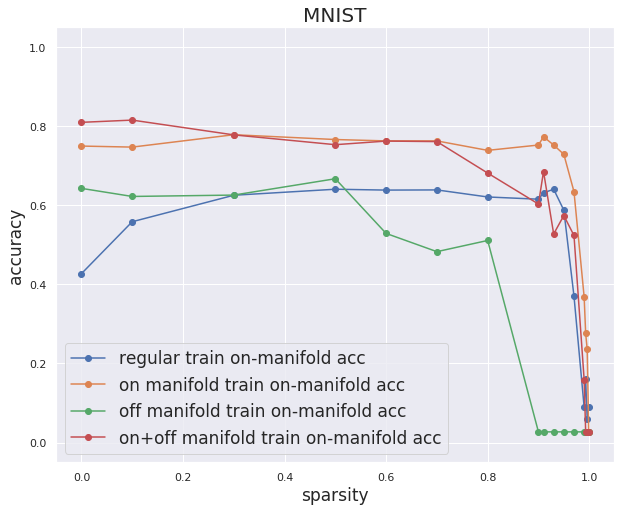

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(-0.05, 1.05)
plt.plot(acc_data['sparsity'], acc_data['normal_onadv_acc'], '-o', label='regular train on-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['on_onadv_acc'], '-o', label='on manifold train on-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['off_onadv_acc'], '-o', label='off manifold train on-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['onoff_onadv_acc'], '-o', label='on+off manifold train on-manifold acc')

plt.title('MNIST', fontsize=20)
plt.xlabel('sparsity', fontsize=17)
plt.ylabel('accuracy', fontsize=17)
plt.legend(fontsize=17)

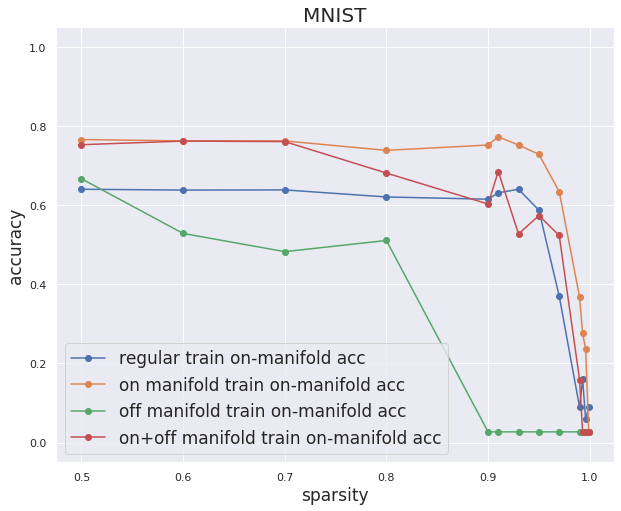

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(-0.05, 1.05)
plt.plot(acc_data['sparsity'][3:], acc_data['normal_onadv_acc'][3:], '-o', label='regular train on-manifold acc')
plt.plot(acc_data['sparsity'][3:], acc_data['on_onadv_acc'][3:], '-o', label='on manifold train on-manifold acc')
plt.plot(acc_data['sparsity'][3:], acc_data['off_onadv_acc'][3:], '-o', label='off manifold train on-manifold acc')
plt.plot(acc_data['sparsity'][3:], acc_data['onoff_onadv_acc'][3:], '-o', label='on+off manifold train on-manifold acc')

plt.title('MNIST', fontsize=20)
plt.xlabel('sparsity', fontsize=17)
plt.ylabel('accuracy', fontsize=17)
plt.legend(fontsize=17)

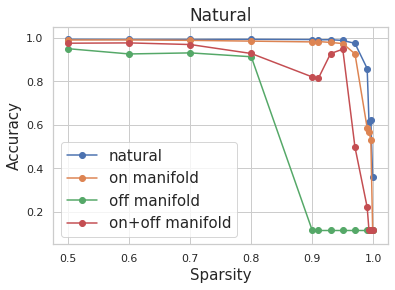

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
# plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'][3:], acc_data['normal_acc'][3:], '-o', label='natural')
plt.plot(acc_data['sparsity'][3:], acc_data['on_acc'][3:], '-o', label='on manifold')
plt.plot(acc_data['sparsity'][3:], acc_data['off_acc'][3:], '-o', label='off manifold')
plt.plot(acc_data['sparsity'][3:], acc_data['onoff_acc'][3:], '-o', label='on+off manifold')

plt.title('Natural', fontsize=17)
plt.xlabel('Sparsity', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)

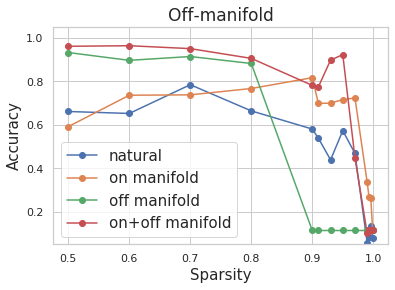

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
# plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'][3:], acc_data['normal_adv_acc'][3:], '-o', label='natural')
plt.plot(acc_data['sparsity'][3:], acc_data['on_adv_acc'][3:], '-o', label='on manifold')
plt.plot(acc_data['sparsity'][3:], acc_data['off_adv_acc'][3:], '-o', label='off manifold')
plt.plot(acc_data['sparsity'][3:], acc_data['onoff_adv_acc'][3:], '-o', label='on+off manifold')

plt.title('Off-manifold', fontsize=17)
plt.xlabel('Sparsity', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)

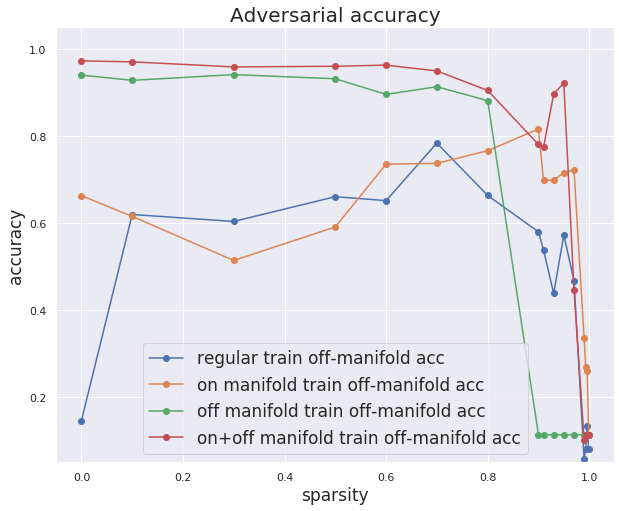

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'], acc_data['normal_adv_acc'], '-o', label='regular train off-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['on_adv_acc'], '-o', label='on manifold train off-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['off_adv_acc'], '-o', label='off manifold train off-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['onoff_adv_acc'], '-o', label='on+off manifold train off-manifold acc')

plt.title('Adversarial accuracy', fontsize=20)
plt.xlabel('sparsity', fontsize=17)
plt.ylabel('accuracy', fontsize=17)
plt.legend(fontsize=17)

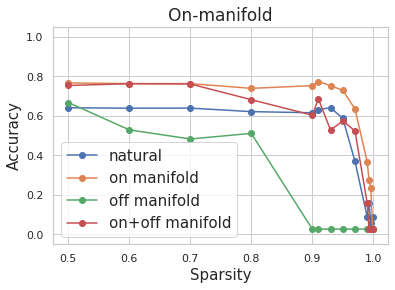

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()
# plt.figure(figsize=(10,8))
plt.ylim(-0.05, 1.05)
plt.plot(acc_data['sparsity'][3:], acc_data['normal_onadv_acc'][3:], '-o', label='natural')
plt.plot(acc_data['sparsity'][3:], acc_data['on_onadv_acc'][3:], '-o', label='on manifold')
plt.plot(acc_data['sparsity'][3:], acc_data['off_onadv_acc'][3:], '-o', label='off manifold')
plt.plot(acc_data['sparsity'][3:], acc_data['onoff_onadv_acc'][3:], '-o', label='on+off manifold')

plt.title('On-manifold', fontsize=17)
plt.xlabel('Sparsity', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)

In [47]:
data_loader, test_loader, _ = mnist(128)
clf = ClassifierTrainer('lenet', 1, data_loader, test_loader)

In [48]:
my_file = Path('./simulation/%s/%s_v2_%s_sparsity%s.pt' % (
    'MNIST', 'robust_train', 'lenet', str(0.99).replace('.', '_')))

print('loading ', my_file)
clf_state = torch.load(my_file)
clf.classifier.load_state_dict(clf_state)
classifier = clf.classifier

loading  simulation/MNIST/robust_train_v2_lenet_sparsity0_99.pt


In [56]:
classifier.fcs.fc1.weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1', requires_grad=True)

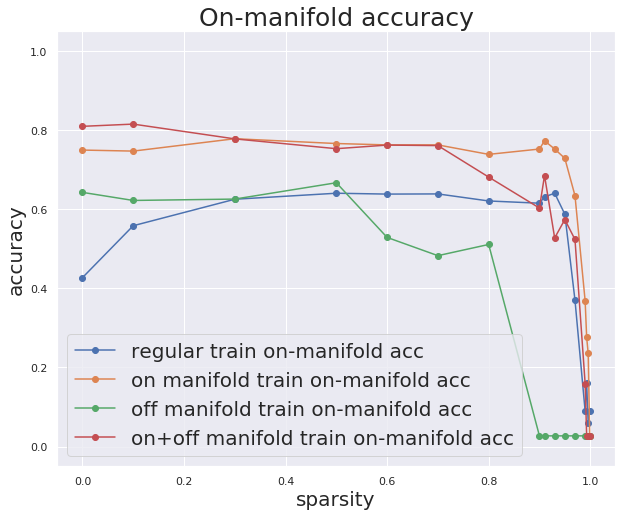

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(-0.05, 1.05)
plt.plot(acc_data['sparsity'], acc_data['normal_onadv_acc'], '-o', label='regular train on-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['on_onadv_acc'], '-o', label='on manifold train on-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['off_onadv_acc'], '-o', label='off manifold train on-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['onoff_onadv_acc'], '-o', label='on+off manifold train on-manifold acc')

plt.title('On-manifold accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

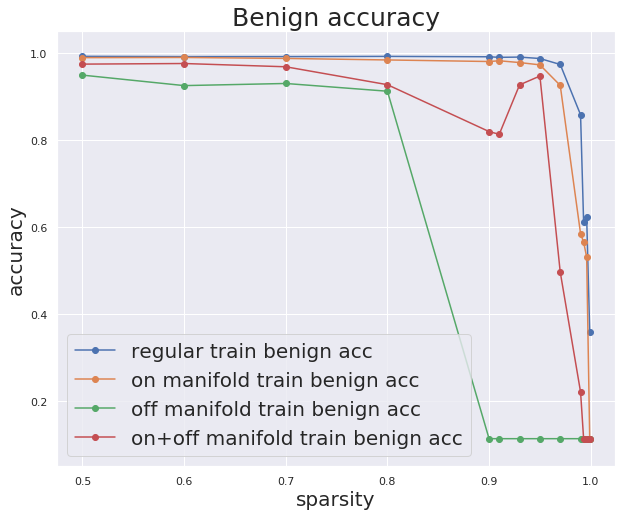

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'][3:], acc_data['normal_acc'][3:], '-o', label='regular train benign acc')
plt.plot(acc_data['sparsity'][3:], acc_data['on_acc'][3:], '-o', label='on manifold train benign acc')
plt.plot(acc_data['sparsity'][3:], acc_data['off_acc'][3:], '-o', label='off manifold train benign acc')
plt.plot(acc_data['sparsity'][3:], acc_data['onoff_acc'][3:], '-o', label='on+off manifold train benign acc')

plt.title('Benign accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

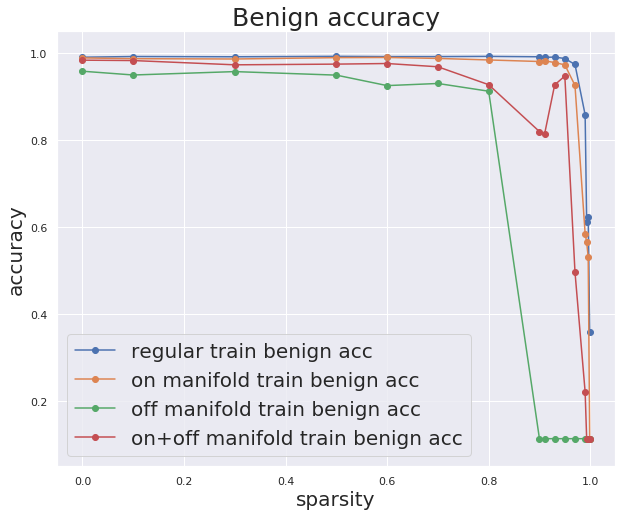

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'], acc_data['normal_acc'], '-o', label='regular train benign acc')
plt.plot(acc_data['sparsity'], acc_data['on_acc'], '-o', label='on manifold train benign acc')
plt.plot(acc_data['sparsity'], acc_data['off_acc'], '-o', label='off manifold train benign acc')
plt.plot(acc_data['sparsity'], acc_data['onoff_acc'], '-o', label='on+off manifold train benign acc')

plt.title('Benign accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

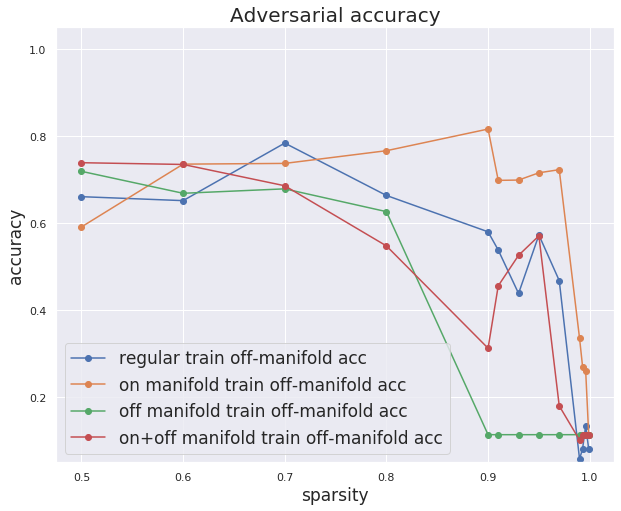

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'][3:], acc_data['normal_adv_acc'][3:], '-o', label='regular train off-manifold acc')
plt.plot(acc_data['sparsity'][3:], acc_data['on_adv_acc'][3:], '-o', label='on manifold train off-manifold acc')
plt.plot(acc_data['sparsity'][3:], acc_data['off_adv_acc'][3:], '-o', label='off manifold train off-manifold acc')
plt.plot(acc_data['sparsity'][3:], acc_data['onoff_adv_acc'][3:], '-o', label='on+off manifold train off-manifold acc')

plt.title('Adversarial accuracy', fontsize=20)
plt.xlabel('sparsity', fontsize=17)
plt.ylabel('accuracy', fontsize=17)
plt.legend(fontsize=17)

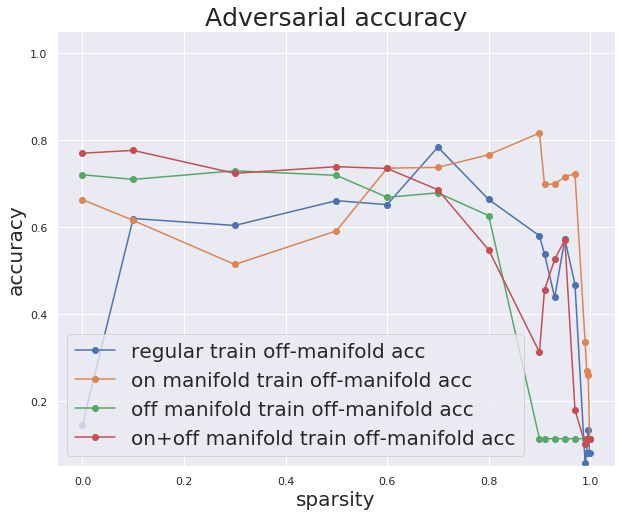

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(acc_data['sparsity'], acc_data['normal_adv_acc'], '-o', label='regular train off-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['on_adv_acc'], '-o', label='on manifold train off-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['off_adv_acc'], '-o', label='off manifold train off-manifold acc')
plt.plot(acc_data['sparsity'], acc_data['onoff_adv_acc'], '-o', label='on+off manifold train off-manifold acc')

plt.title('Adversarial accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

In [ ]:
plt.figure(figsize=(10,8))
plt.ylim((0., 1.01))

mean = softmax_df['normal_adv_softmax_mean']
var = softmax_df['normal_adv_softmax_var']
plt.plot(acc_data['sparsity'], mean, 'o-', label='naive training adv softmax')
plt.fill_between(acc_data['sparsity'], mean-var, mean+var, alpha=0.2)
mean = softmax_df['on_adv_softmax_mean']
var = softmax_df['on_adv_softmax_var']
plt.plot(acc_data['sparsity'], mean, 'o-', label='on AT adv softmax')
plt.fill_between(acc_data['sparsity'], mean-var, mean+var, alpha=0.2)
mean = softmax_df['off_adv_softmax_mean']
var = softmax_df['off_adv_softmax_var']
plt.plot(acc_data['sparsity'], mean, 'o-', label='off AT adv softmax')
plt.fill_between(acc_data['sparsity'], mean-var, mean+var, alpha=0.2)
mean = softmax_df['onoff_adv_softmax_mean']
var = softmax_df['onoff_adv_softmax_var']
plt.plot(acc_data['sparsity'], mean, 'o-', label='on+off AT adv softmax')
plt.fill_between(acc_data['sparsity'], mean-var, mean+var, alpha=0.2)


plt.xlabel('sparsity', fontsize=20)
plt.ylabel('softmax', fontsize=20)
plt.title('Adversarial example max softmax plot', fontsize=25)
plt.legend(fontsize=20)
plt.show()

In [36]:
 in softmax_df.keys()

False

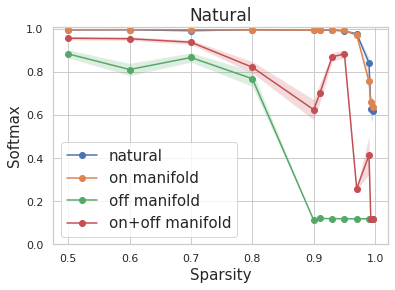

In [26]:
# plt.figure(figsize=(10,8))
plt.ylim((0., 1.01))

rang = (3, -1)

mean = softmax_df['normal_benign_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['normal_benign_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='natural')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['on_benign_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['on_benign_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='on manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['off_benign_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['off_benign_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='off manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['onoff_benign_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['onoff_benign_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='on+off manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)


plt.xlabel('Sparsity', fontsize=15)
plt.ylabel('Softmax', fontsize=15)
plt.title('Natural', fontsize=17)
plt.legend(fontsize=15)
plt.show()

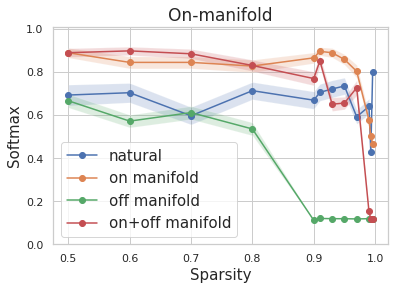

In [27]:
# plt.figure(figsize=(10,8))
plt.ylim((0., 1.01))

rang = (3, -1)

mean = softmax_df['normal_onadv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['normal_onadv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='natural')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['on_onadv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['on_onadv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='on manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['off_onadv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['off_onadv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='off manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['onoff_onadv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['onoff_onadv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='on+off manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)


plt.xlabel('Sparsity', fontsize=15)
plt.ylabel('Softmax', fontsize=15)
plt.title('On-manifold', fontsize=17)
plt.legend(fontsize=15)
plt.show()

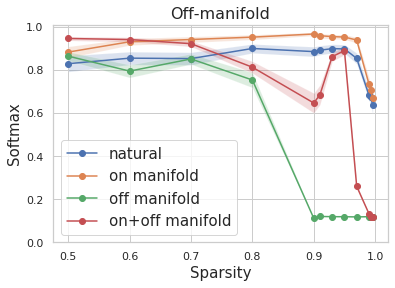

In [28]:
# plt.figure(figsize=(10,8))
plt.ylim((0., 1.01))

mean = softmax_df['normal_adv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['normal_adv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='natural')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['on_adv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['on_adv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='on manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['off_adv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['off_adv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='off manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)
mean = softmax_df['onoff_adv_softmax_mean'][rang[0]:rang[1]]
var = softmax_df['onoff_adv_softmax_var'][rang[0]:rang[1]]
plt.plot(acc_data['sparsity'][rang[0]:rang[1]], mean, 'o-', label='on+off manifold')
plt.fill_between(acc_data['sparsity'][rang[0]:rang[1]], mean-var, mean+var, alpha=0.2)


plt.xlabel('Sparsity', fontsize=15)
plt.ylabel('Softmax', fontsize=15)
plt.title('Off-manifold', fontsize=16)
plt.legend(fontsize=15)
plt.show()

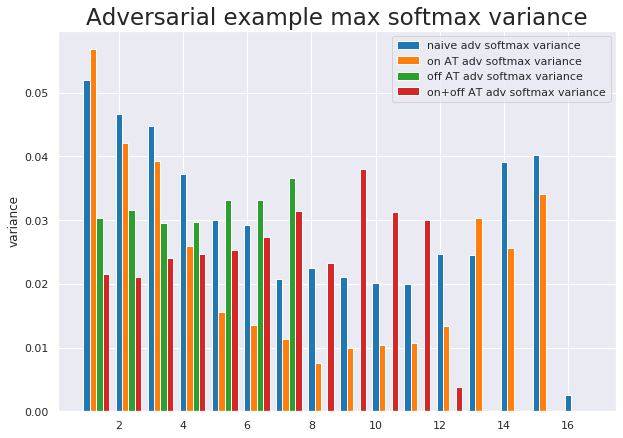

In [21]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(softmax_df['normal_adv_softmax_var']) + 1)

y = softmax_df['normal_adv_softmax_var']
ax.bar(x, y, width=0.2, color='tab:blue', align='center', label='naive adv softmax variance')
z = softmax_df['on_adv_softmax_var']
ax.bar(x+0.2, z, width=0.2, color='tab:orange', align='center', label='on AT adv softmax variance')
k = softmax_df['off_adv_softmax_var']
ax.bar(x+0.4, k, width=0.2, color='tab:green', align='center', label='off AT adv softmax variance')
k = softmax_df['onoff_adv_softmax_var']
ax.bar(x+0.6, k, width=0.2, color='tab:red', align='center', label='on+off AT adv softmax variance')

ax.set_title('Adversarial example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

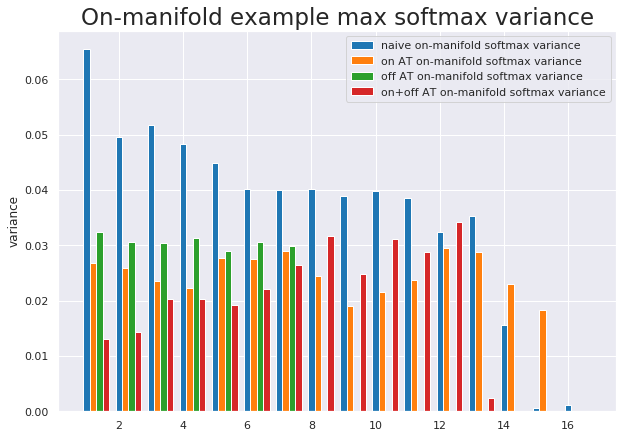

In [26]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(softmax_df['normal_onadv_softmax_var']) + 1)

y = softmax_df['normal_onadv_softmax_var']
ax.bar(x, y, width=0.2, color='tab:blue', align='center', label='naive on-manifold softmax variance')
z = softmax_df['on_onadv_softmax_var']
ax.bar(x+0.2, z, width=0.2, color='tab:orange', align='center', label='on AT on-manifold softmax variance')
k = softmax_df['off_onadv_softmax_var']
ax.bar(x+0.4, k, width=0.2, color='tab:green', align='center', label='off AT on-manifold softmax variance')
k = softmax_df['onoff_onadv_softmax_var']
ax.bar(x+0.6, k, width=0.2, color='tab:red', align='center', label='on+off AT on-manifold softmax variance')

ax.set_title('On-manifold example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

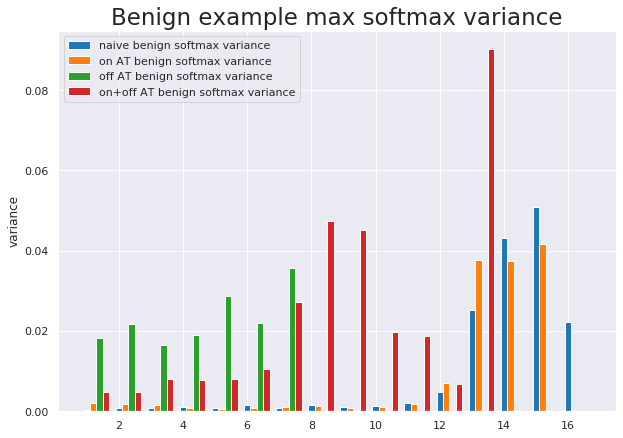

In [29]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(softmax_df['normal_adv_softmax_var']) + 1)

y = softmax_df['normal_benign_softmax_var']
ax.bar(x, y, width=0.2, color='tab:blue', align='center', label='naive benign softmax variance')
z = softmax_df['on_benign_softmax_var']
ax.bar(x+0.2, z, width=0.2, color='tab:orange', align='center', label='on AT benign softmax variance')
k = softmax_df['off_benign_softmax_var']
ax.bar(x+0.4, k, width=0.2, color='tab:green', align='center', label='off AT benign softmax variance')
k = softmax_df['onoff_benign_softmax_var']
ax.bar(x+0.6, k, width=0.2, color='tab:red', align='center', label='on+off AT benign softmax variance')

ax.set_title('Benign example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

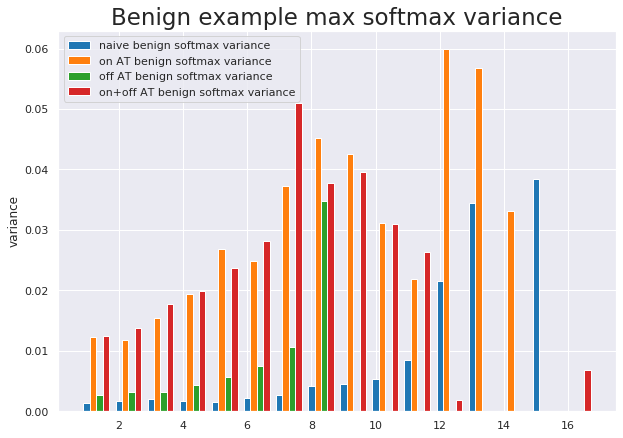

In [88]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(softmax_df['normal_adv_softmax_var']) + 1)

y = softmax_df['normal_benign_softmax_var']
ax.bar(x, y, width=0.2, color='tab:blue', align='center', label='naive benign softmax variance')
z = softmax_df['on_benign_softmax_var']
ax.bar(x+0.2, z, width=0.2, color='tab:orange', align='center', label='on AT benign softmax variance')
k = softmax_df['off_benign_softmax_var']
ax.bar(x+0.4, k, width=0.2, color='tab:green', align='center', label='off AT benign softmax variance')
k = softmax_df['onoff_benign_softmax_var']
ax.bar(x+0.6, k, width=0.2, color='tab:red', align='center', label='on+off AT benign softmax variance')

ax.set_title('Benign example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

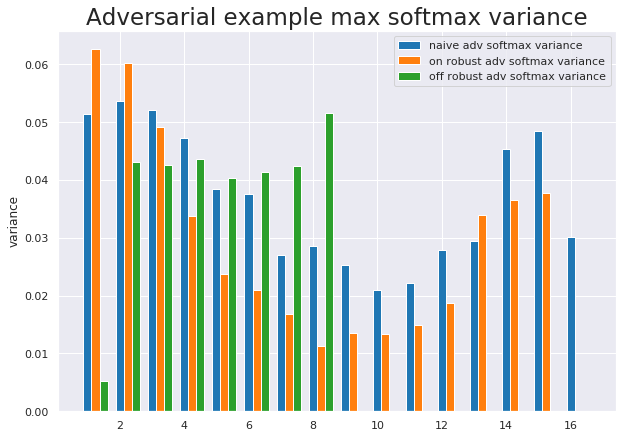

In [28]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(adv_softmax1.max(axis=2).var(axis=1)) + 1)

y = adv_softmax1.max(axis=2).var(axis=1)
ax.bar(x, y, width=0.2, color='tab:blue', align='center', label='naive adv softmax variance')
z = adv_softmax2.max(axis=2).var(axis=1)
ax.bar(x+0.2, z, width=0.2, color='tab:orange', align='center', label='on robust adv softmax variance')
k = adv_softmax3.max(axis=2).var(axis=1)
ax.bar(x+0.4, k, width=0.2, color='tab:green', align='center', label='off robust adv softmax variance')
k = adv_softmax3.max(axis=2).var(axis=1)
ax.bar(x+0.6, k, width=0.2, color='tab:green', align='center', label='off robust adv softmax variance')

ax.set_title('Adversarial example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

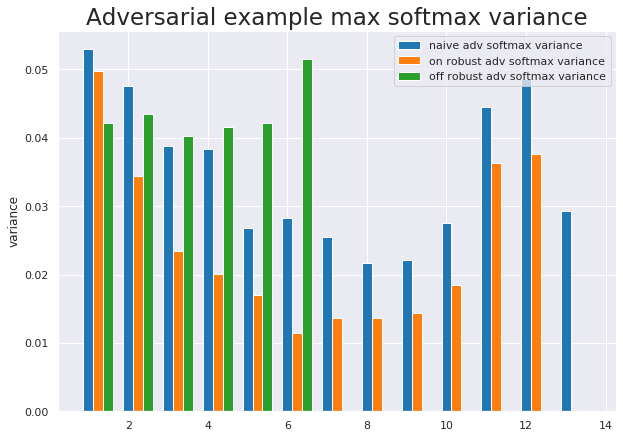

In [162]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(adv_softmax1.max(axis=2).var(axis=1)) + 1)

y = adv_softmax1.max(axis=2).var(axis=1)
ax.bar(x, y, width=0.25, color='tab:blue', align='center', label='naive adv softmax variance')
z = adv_softmax2.max(axis=2).var(axis=1)
ax.bar(x+0.25, z, width=0.25, color='tab:orange', align='center', label='on robust adv softmax variance')
k = adv_softmax3.max(axis=2).var(axis=1)
ax.bar(x+0.5, k, width=0.25, color='tab:green', align='center', label='off robust adv softmax variance')
ax.set_title('Adversarial example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

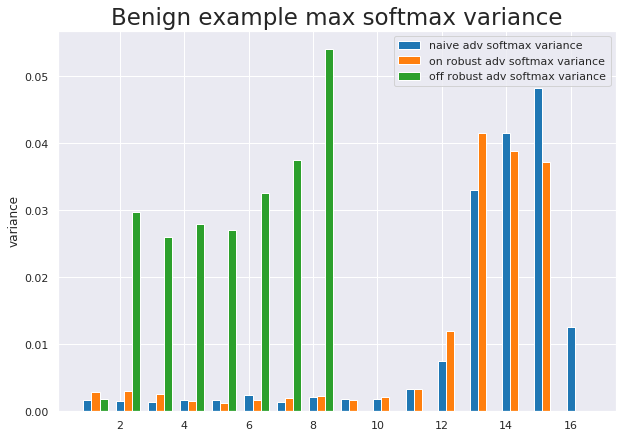

In [29]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

x = np.arange(1, len(benign_softmax1.max(axis=2).var(axis=1)) + 1)

y = benign_softmax1.max(axis=2).var(axis=1)
ax.bar(x, y, width=0.25, color='tab:blue', align='center', label='naive adv softmax variance')
z = benign_softmax2.max(axis=2).var(axis=1)
ax.bar(x+0.25, z, width=0.25, color='tab:orange', align='center', label='on robust adv softmax variance')
k = benign_softmax3.max(axis=2).var(axis=1)
ax.bar(x+0.5, k, width=0.25, color='tab:green', align='center', label='off robust adv softmax variance')
ax.set_title('Benign example max softmax variance', fontsize=23)
ax.set_ylabel('variance')
plt.legend()

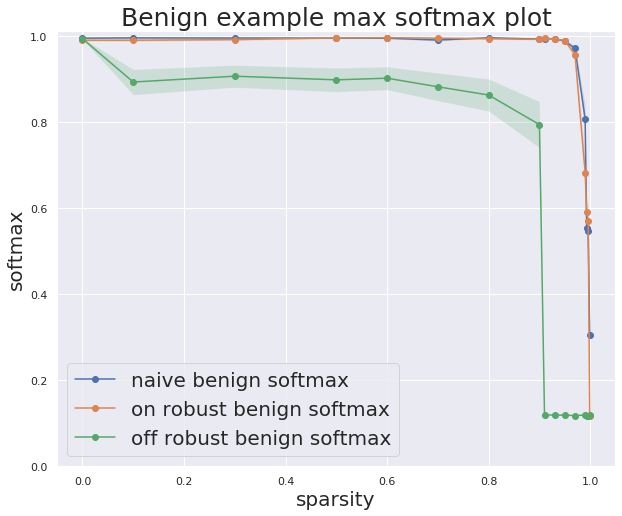

In [30]:
plt.figure(figsize=(10,8))
plt.ylim((0., 1.01))
plt.plot(sparsity_ratio_list, benign_softmax1.max(axis=2).mean(axis=1), 'o-', label='naive benign softmax')
plt.fill_between(sparsity_ratio_list, benign_softmax1.max(axis=2).mean(axis=1)-benign_softmax1.max(axis=2).var(axis=1), benign_softmax1.max(axis=2).mean(axis=1)+benign_softmax1.max(axis=2).var(axis=1), alpha=0.2)
plt.plot(sparsity_ratio_list, benign_softmax2.max(axis=2).mean(axis=1), 'o-', label='on robust benign softmax')
plt.fill_between(sparsity_ratio_list, benign_softmax2.max(axis=2).mean(axis=1)-benign_softmax2.max(axis=2).var(axis=1), benign_softmax2.max(axis=2).mean(axis=1)+benign_softmax2.max(axis=2).var(axis=1), alpha=0.2)
plt.plot(sparsity_ratio_list, benign_softmax3.max(axis=2).mean(axis=1), 'o-', label='off robust benign softmax')
plt.fill_between(sparsity_ratio_list, benign_softmax3.max(axis=2).mean(axis=1)-benign_softmax3.max(axis=2).var(axis=1), benign_softmax3.max(axis=2).mean(axis=1)+benign_softmax3.max(axis=2).var(axis=1), alpha=0.2)
# plt.plot(sparsity_ratio_list, adv_softmax1.max(axis=2).mean(axis=1), 'o-', label='naive adv softmax')
# plt.fill_between(sparsity_ratio_list, adv_softmax1.max(axis=2).mean(axis=1)-adv_softmax1.max(axis=2).var(axis=1), adv_softmax1.max(axis=2).mean(axis=1)+adv_softmax1.max(axis=2).var(axis=1), alpha=0.2, label='variance')
# plt.plot(sparsity_ratio_list, adv_softmax2.max(axis=2).mean(axis=1), 'o-', label='on robust adv softmax')
# plt.fill_between(sparsity_ratio_list, adv_softmax2.max(axis=2).mean(axis=1)-adv_softmax2.max(axis=2).var(axis=1), adv_softmax2.max(axis=2).mean(axis=1)+adv_softmax2.max(axis=2).var(axis=1), alpha=0.2, label='variance')
# plt.plot(sparsity_ratio_list, adv_softmax3.max(axis=2).mean(axis=1), 'o-', label='off robust adv softmax')
# plt.fill_between(sparsity_ratio_list, adv_softmax3.max(axis=2).mean(axis=1)-adv_softmax3.max(axis=2).var(axis=1), adv_softmax3.max(axis=2).mean(axis=1)+adv_softmax3.max(axis=2).var(axis=1), alpha=0.2, label='variance')

plt.xlabel('sparsity', fontsize=20)
plt.ylabel('softmax', fontsize=20)
plt.title('Benign example max softmax plot', fontsize=25)
plt.legend(fontsize=20)
plt.show()

In [19]:
from numpy import dot
from numpy.linalg import norm

Naive = np.array(adv_lists)
AT = np.array(adv_lists2)
orig_AT = np.array(adv_lists3)

AT = AT.squeeze(axis=2)
orig_AT = orig_AT.squeeze(axis=2)
Naive = Naive.squeeze(axis=2)

In [90]:
def cosine_distance(a, b):
    if a.shape != b.shape:
        raise RuntimeError("array {} shape not match {}".format(a.shape, b.shape))
    if a.ndim==1:
        a_norm = np.linalg.norm(a)
        b_norm = np.linalg.norm(b)
    elif a.ndim==2:
        a_norm = np.linalg.norm(a, axis=1, keepdims=True)
        b_norm = np.linalg.norm(b, axis=1, keepdims=True)
    else:
        raise RuntimeError("array dimensions {} not right".format(a.ndim))
    #similiarity = np.dot(a, b.T)/(a_norm * b_norm) 
    similiarity = np.matmul(a, b)/(a_norm * b_norm) 
    dist = 1. - similiarity
    return dist

In [96]:
cos_sim = []
cos_sim2 = []
cos_sim3 = []
for i in range(0,len(sparsity_ratio_list)):
    cos_sim.append( [cosine_distance(a,b) for a, b in zip(AT[i], Naive[i])] )
    cos_sim2.append( [cosine_distance(a,b) for a, b in zip(orig_AT[i], Naive[i])] )
    cos_sim3.append( [cosine_distance(a,b) for a, b in zip(orig_AT[i], AT[i])] )
cos_sim = np.array(cos_sim)   
cos_sim2 = np.array(cos_sim2)   
cos_sim3 = np.array(cos_sim3)   

In [13]:
benign_adv_acc, robust_adv_acc

([0.9418, 0.9085, 0.9047, 0.8887, 0.2492, 0.2196, 0.141],
 [0.9498, 0.9355, 0.9114, 0.8105, 0.3215, 0.2967, 0.1135])

In [14]:
[benign_acc2,benign_adv_acc2,robust_acc2,robust_adv_acc2] = load_data('./simulation/result2.pkl')

In [17]:
benign_acc2.append(benign_acc)
benign_adv_acc2.append(benign_adv_acc)
robust_acc2.append(robust_acc)
robust_adv_acc2.append(robust_adv_acc)

In [30]:
benign_acc2 = [0.9923,0.9917,0.9927,0.9921, 0.9917, 0.9904, 0.991, 0.9877, 0.974, 0.6117, 0.6238, 0.3597]
benign_adv_acc2 =[0.9569, 0.9551, 0.9564, 0.9573, 0.9436, 0.9418, 0.9085, 0.9047, 0.8887, 0.2492, 0.2196, 0.141]
robust_acc2 = [0.9873, 0.9866, 0.9897, 0.9879, 0.9808, 0.9825, 0.9784, 0.9731, 0.9259, 0.5653, 0.5315, 0.1135]
robust_adv_acc2 = [0.9195, 0.9164, 0.9262, 0.9544, 0.9398, 0.9498, 0.9355, 0.9114, 0.8105, 0.3215, 0.2967, 0.1135]

In [20]:
import matplotlib.pyplot as plt
n_cov = [np.cov(n.reshape(n.shape[0], -1)) for n in Naive]
a_cov = [np.cov(a.reshape(a.shape[0], -1)) for a in AT]
oa_cov = [np.cov(oa.reshape(oa.shape[0], -1)) for oa in orig_AT]
#sns.pairplot(pd.DataFrame(n_cov[0]))

In [28]:
sparsity_ratio_list = [0.3, 0.5, 0.6, 0.7,0.8, 0.9, 0.91, 0.93, 0.95, 0.97, 0.993, 0.996, 0.999]

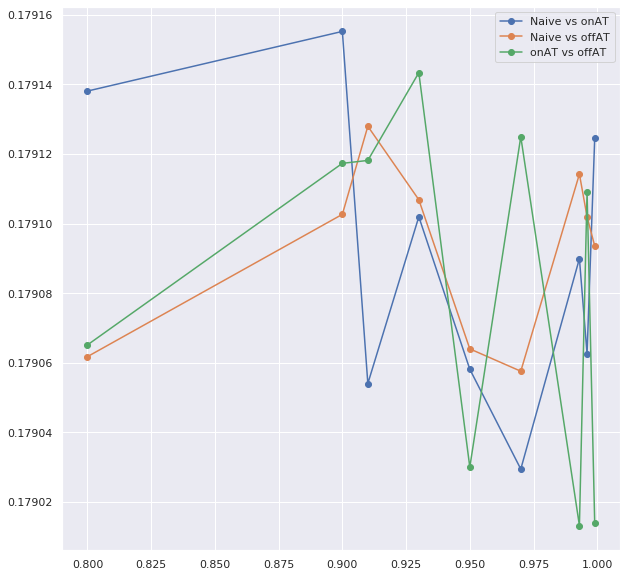

In [97]:
plt.figure(figsize=(10, 10))

plt.plot(sparsity_ratio_list[4:], [np.std(cos_sim[i]) for i in range(0,13)][4:],'-o', label='Naive vs onAT')
plt.plot(sparsity_ratio_list[4:], [np.std(cos_sim2[i]) for i in range(0,13)][4:],'-o', label='Naive vs offAT')
plt.plot(sparsity_ratio_list[4:], [np.std(cos_sim3[i]) for i in range(0,13)][4:],'-o', label='onAT vs offAT')

plt.legend()
plt.show()

In [69]:
np.array([np.mean(cos_sim[i]) for i in range(0,13)])

array([-7.5760392e-05, -3.2147200e-05, -1.8702420e-05,  3.9220558e-05,
       -5.1397656e-05, -1.4027776e-05,  5.7219051e-05, -5.1816573e-05,
        2.0525300e-05, -7.6850825e-05,  6.3424377e-05, -2.0423378e-05,
        4.2845379e-05], dtype=float32)

In [70]:
np.array([np.mean(cos_sim2[i]) for i in range(0,13)])

array([-6.07880283e-05, -6.65642756e-06,  1.23851805e-05, -1.16565088e-05,
        5.42561647e-05, -8.74838406e-06, -2.54636798e-05,  2.73504083e-05,
       -7.99358604e-05, -2.18720143e-05, -3.04942878e-05, -3.20667386e-05,
       -5.25708492e-06], dtype=float32)

In [71]:
np.array([np.mean(cos_sim3[i]) for i in range(0,13)])

array([-8.1228849e-05, -7.4101163e-06, -4.6262794e-05,  9.0020858e-06,
       -3.7724763e-05, -6.6678447e-05, -4.8451184e-05,  1.7763714e-05,
       -3.8786977e-05, -6.7036046e-05,  7.5948803e-05,  5.0608523e-05,
        7.5466633e-05], dtype=float32)

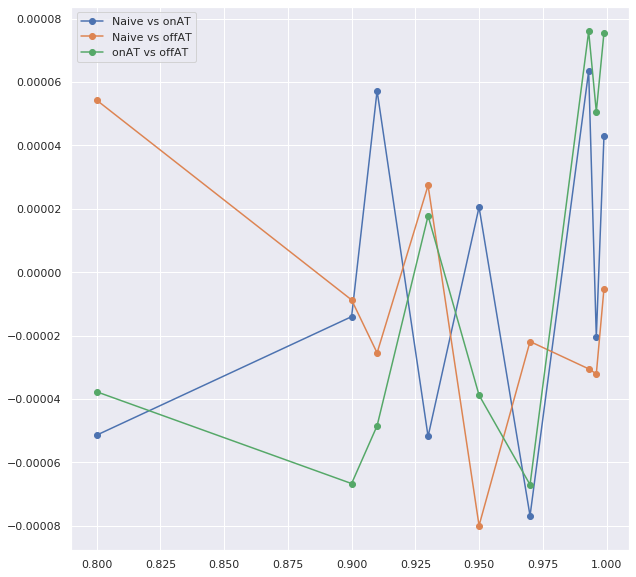

In [72]:
plt.figure(figsize=(10, 10))

#plt.ylim(0, )

plt.plot(sparsity_ratio_list[4:], [np.mean(cos_sim[i]) for i in range(0,13)][4:],'-o', label='Naive vs onAT')
plt.plot(sparsity_ratio_list[4:], [np.mean(cos_sim2[i]) for i in range(0,13)][4:],'-o', label='Naive vs offAT')
plt.plot(sparsity_ratio_list[4:], [np.mean(cos_sim3[i]) for i in range(0,13)][4:],'-o', label='onAT vs offAT')


#x = sparsity_ratio_list[4:]
#y = np.array([np.mean(cos_sim[i]) for i in range(0,13)])[4:]
#e = np.array([np.std(cos_sim[i]) for i in range(0,13)])[4:]
#plt.errorbar(x, y, e, linestyle='None', marker='^')

#plt.fill_between(sparsity_ratio_list[4:], np.array([np.mean(cos_sim[i]) for i in range(0,13)])[4:] - np.array([np.std(cos_sim[i]) for i in range(0,13)])[4:], 
#                 np.array([np.mean(cos_sim[i]) for i in range(0,13)])[4:] + np.array([np.std(cos_sim[i]) for i in range(0,13)])[4:],alpha = 0.3)

#plt.fill_between(sparsity_ratio_list[4:], np.array([np.mean(cos_sim3[i]) for i in range(0,13)])[4:] - np.array([np.std(cos_sim3[i]) for i in range(0,13)])[4:], 
#                 np.array([np.mean(cos_sim3[i]) for i in range(0,13)])[4:] + np.array([np.std(cos_sim3[i]) for i in range(0,13)])[4:])
    

plt.legend()
plt.show()

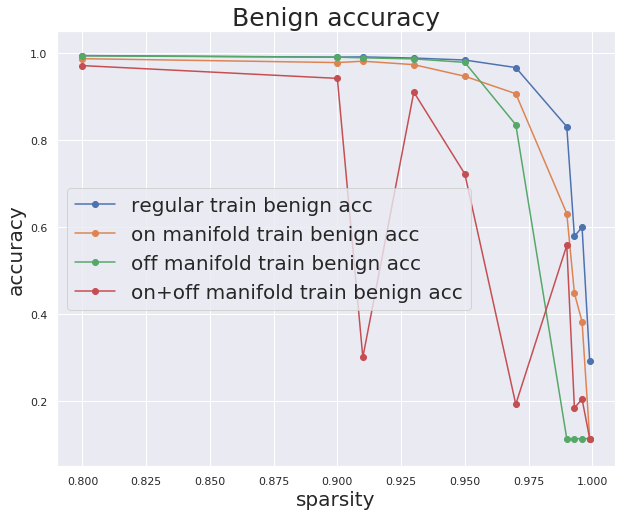

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(sparsity_ratio_list[6:], benign_acc[6:], '-o', label='regular train benign acc')
plt.plot(sparsity_ratio_list[6:], robust_acc[6:], '-o', label='on manifold train benign acc')
plt.plot(sparsity_ratio_list[6:], offrobust_acc[6:], '-o', label='off manifold train benign acc')
plt.plot(sparsity_ratio_list[6:], onoffrobust_acc[6:], '-o', label='on+off manifold train benign acc')

plt.title('Benign accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

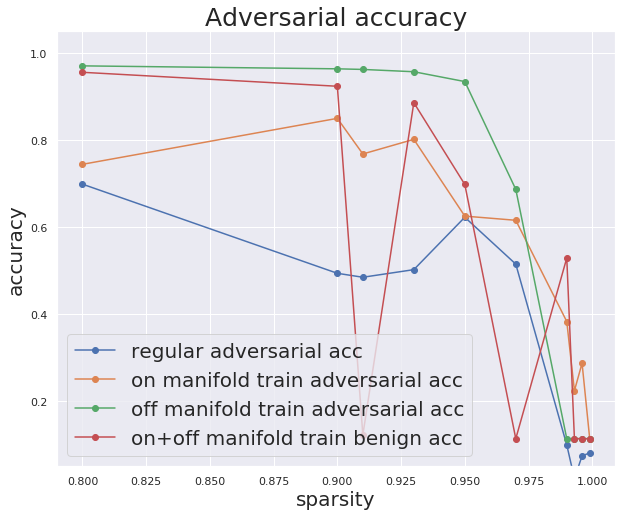

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
plt.ylim(0.05, 1.05)
plt.plot(sparsity_ratio_list[6:], benign_adv_acc[6:], '-o', label='regular adversarial acc')
plt.plot(sparsity_ratio_list[6:], robust_adv_acc[6:], '-o', label='on manifold train adversarial acc')
plt.plot(sparsity_ratio_list[6:], offrobust_adv_acc[6:], '-o', label='off manifold train adversarial acc')
plt.plot(sparsity_ratio_list[6:], onoffrobust_adv_acc[6:], '-o', label='on+off manifold train benign acc')

plt.title('Adversarial accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

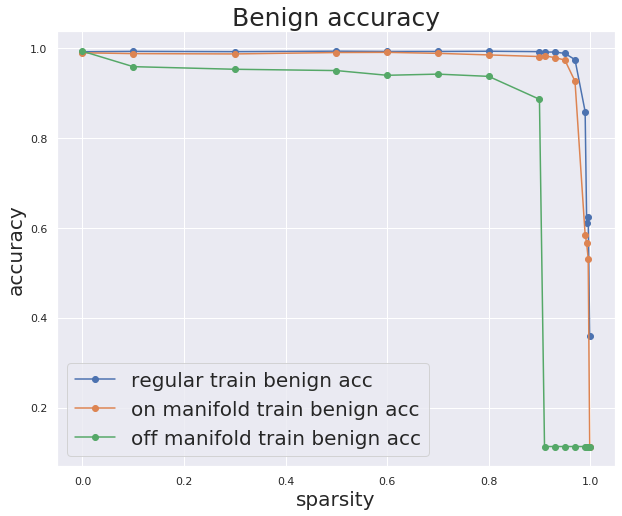

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
#plt.ylim(0.05, 1.05)
plt.plot(sparsity_ratio_list, benign_acc, '-o', label='regular train benign acc')
#plt.plot(sparsity_ratio_list, benign_adv_acc, '-o', label='regular adversarial acc')
plt.plot(sparsity_ratio_list, robust_acc, '-o', label='on manifold train benign acc')
#plt.plot(sparsity_ratio_list, robust_adv_acc, '-o', label='on manifold train adversarial acc')
plt.plot(sparsity_ratio_list, offrobust_acc, '-o', label='off manifold train benign acc')
#plt.plot(sparsity_ratio_list, offrobust_adv_acc, '-o', label='off manifold train adversarial acc')

plt.title('Benign accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

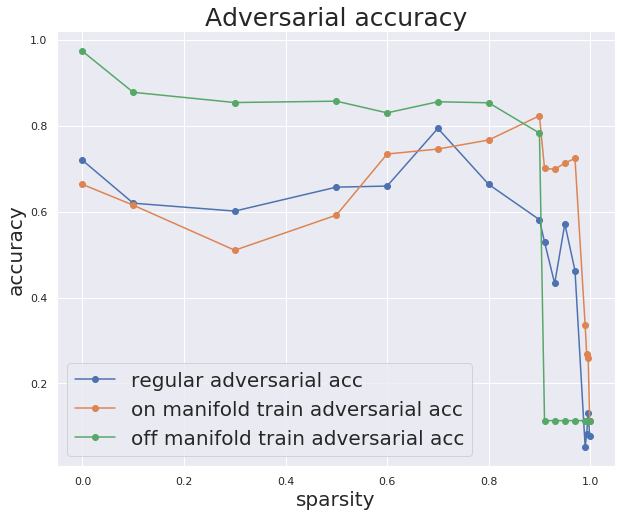

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10,8))
#plt.ylim(0.05, 1.05)
#plt.plot(sparsity_ratio_list, benign_acc, '-o', label='regular train benign acc')
plt.plot(sparsity_ratio_list, benign_adv_acc, '-o', label='regular adversarial acc')
#plt.plot(sparsity_ratio_list, robust_acc, '-o', label='on manifold train benign acc')
plt.plot(sparsity_ratio_list, robust_adv_acc, '-o', label='on manifold train adversarial acc')
#plt.plot(sparsity_ratio_list, offrobust_acc, '-o', label='off manifold train benign acc')
plt.plot(sparsity_ratio_list, offrobust_adv_acc, '-o', label='off manifold train adversarial acc')

plt.title('Adversarial accuracy', fontsize=25)
plt.xlabel('sparsity', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend(fontsize=20)

[5. 7. 2. 1. 2. 4. 6. 2. 8. 0. 3. 3. 4. 2. 7. 1. 8. 0. 6. 9. 1. 5. 9. 8.
 5. 9. 9. 1. 5. 3. 9. 6. 4. 9. 3. 2. 2. 2. 2. 1. 4. 2. 1. 1. 1. 7. 1. 7.
 0. 7. 9. 0. 1. 9. 8. 5. 8. 7. 5. 5. 4. 0. 1. 7.] [5 7 2 1 2 4 6 2 8 0 3 3 4 2 7 1 8 5 1 0 6 9 1 5 9 8 5 9 9 9 1 4 5 3 9 6 4
 9 3 2 2 2 2 4 1 8 4 2 1 1 1 7 1 7 0 7 3 9 0 1 1 9 5 8]


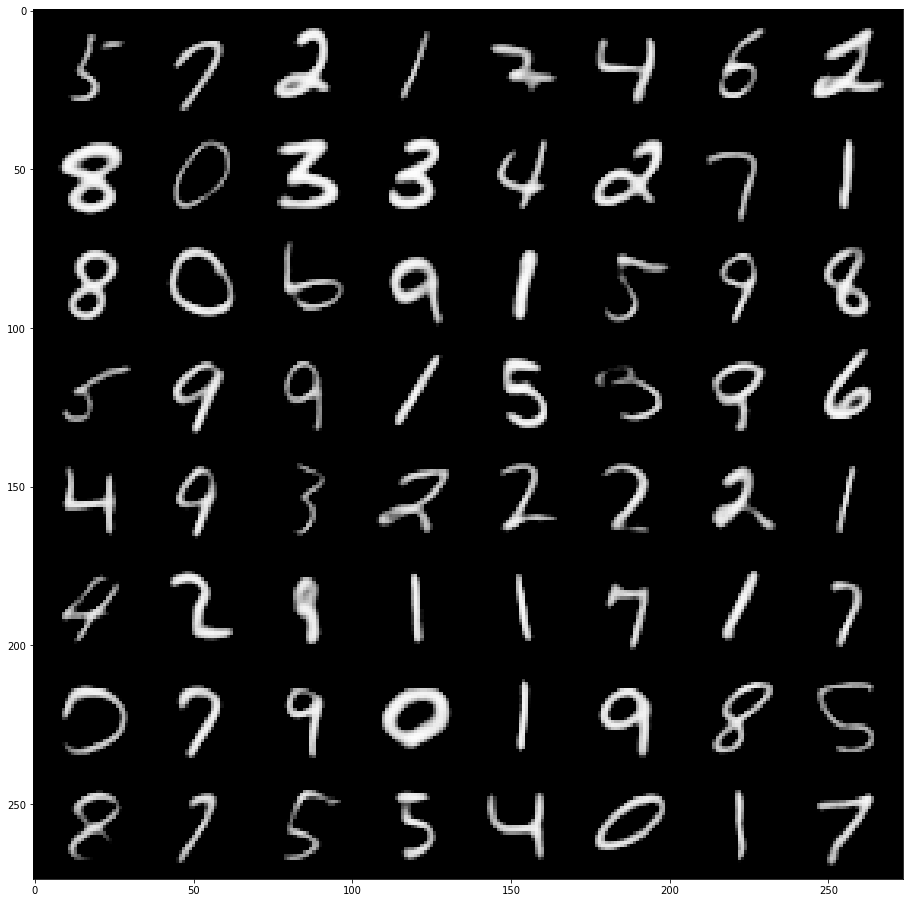

In [84]:
plot_grid(torch.tensor(on_xs[:64]), nrow=8, reg=False)
print(on_ys[:64], on_preds[:64])

In [86]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6 2 7 9 6 4 7 7 0 5 6 9 9 6 6 7 6 3 2 7 3 6 5 5 3 7 2 7 5 9 7 9 3 5 3 2 5
 2 8 3 3 3 7 2 0 7 6 2 3 2 3 4 7 3 3 5 9 5 9 3 9 4 3 2]


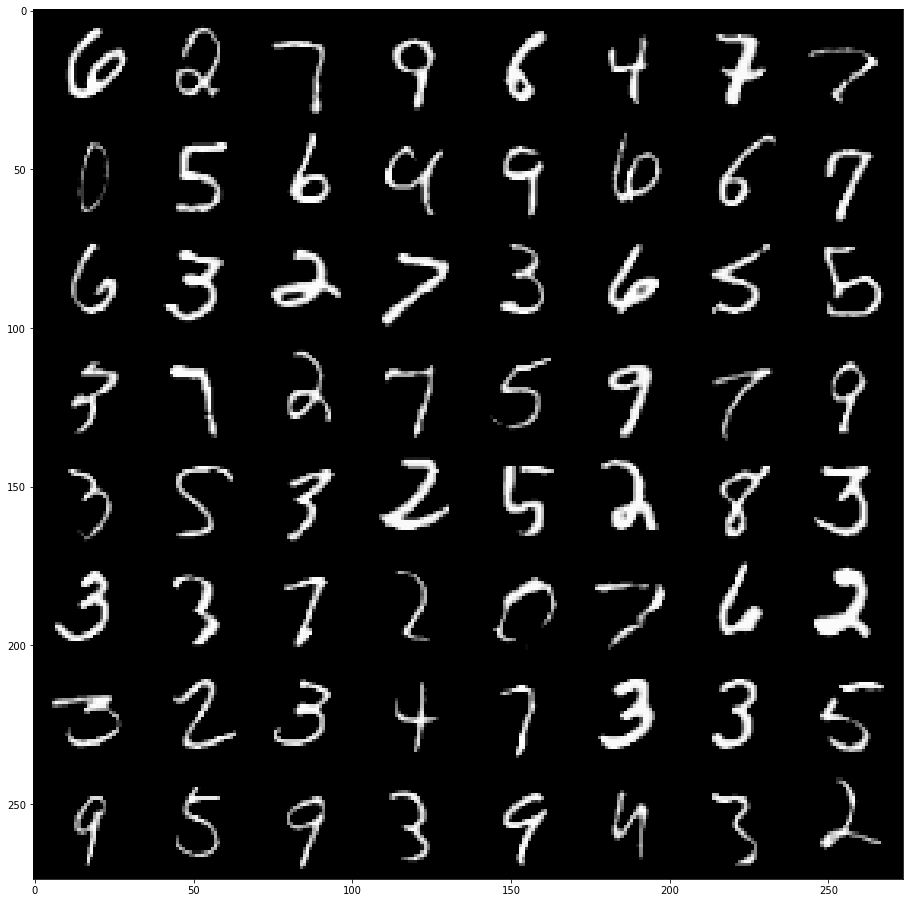

In [197]:
plot_grid(torch.tensor(attack_succ_true[:64]), nrow=8, reg=False)
print(attack_true_label[:64].astype(np.int64))

In [90]:
attack_succ_perturbed.shape

(4862, 1, 32, 32)

## Find latent manifold

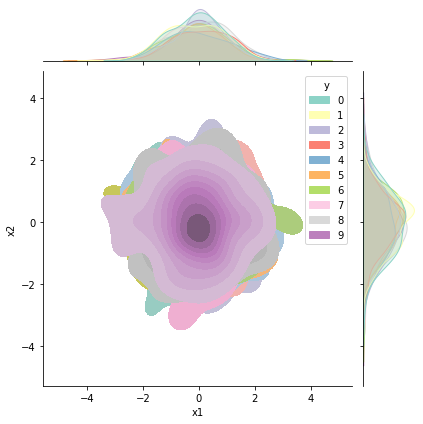

In [192]:
pdd = pd.DataFrame({'x1': z_list[:1000, 0], 'x2': z_list[:1000, 1], 'y': true_label_list[:1000]})
sns.jointplot(data=pdd, x='x1', y='x2', hue='y', kind='kde', palette=sns.color_palette("Set3", 10), fill=False)